In [ ]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [ ]:
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None

    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)

        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])

        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')

        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):
        user_recommendations = self.popularity_recommendations

        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id

        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]

        return user_recommendations

class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None

    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())

        return user_items

    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())

        return item_users

    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())

        return all_items

    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):

        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))

        ###############################################
        #Initialize the item cooccurence matrix of size
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)

        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())

            for j in range(0,len(user_songs)):

                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]

                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)

                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)

                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0


        return cooccurence_matrix


    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))

        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()

        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)

        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)

        #Fill the dataframe with top 10 item based recommendations
        rank = 1
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1

        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df

    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):

      ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)

        print("No. of unique songs for the user: %d" % len(user_songs))

        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()

        print("no. of unique songs in the training set: %d" % len(all_songs))

        ###############################################
        #C. Construct item cooccurence matrix of size
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)

        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)

        return df_recommendations

    #Get similar items to given items
    def get_similar_items(self, item_list):

        user_songs = item_list

        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()

        print("no. of unique songs in the training set: %d" % len(all_songs))

        ###############################################
        #C. Construct item cooccurence matrix of size
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)

        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)

        return df_recommendations


In [5]:
track_metadata_df = pd.read_csv('/content/song_data.csv')
count_play_df = pd.read_csv('/content/10000.txt', sep='\t', header=None, names=['user','song','play_count'])

print('First see of track metadata:')
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())
print('Note the problem with repeated track metadata. Let\'s see of counts play song by users:')
display(count_play_df.shape, count_play_df.head())

First see of track metadata:
Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Note the problem with repeated track metadata. Let's see of counts play song by users:


(2000000, 3)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

print('Number of rows after unique song Id treatment:', unique_track_metadata_df.shape[0])
print('Number of unique songs:', len(unique_track_metadata_df.song_id.unique()))
display(unique_track_metadata_df.head())

Number of rows after unique song Id treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOAAABI12A8C13615F,Afro Jazziac,To Birdland And Hurry,Herbie Mann,2000
1,SOAAABT12AC46860F0,Herre Gud Ditt Dyre Namn Og Ære,Som Den Gyldne Sol Frembryter,Bergen Big Band,0
2,SOAAABX12A8C13FEB2,N.Y.C. Remix,Paris Can´t Wait,Guardner,0
3,SOAAACR12A58A79456,Irresistible,Wowie Zowie,Superchumbo,2002
4,SOAAACY12A58A79663,Untitled 1,Pine Cone Temples,Thuja,0


In [7]:
user_song_list_count = pd.merge(count_play_df,
                                unique_track_metadata_df, how='left',
                                left_on='song',
                                right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])

In [8]:
display(user_song_list_count.head())
user_song_list_count.listen_count.describe().reset_index().T

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,2000000.0,3.045485,6.57972,1.0,1.0,1.0,3.0,2213.0


In [9]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
display(count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T)

118 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,140.0,327.107143,209.11467,201.0,225.0,267.0,353.75,2213.0


In [10]:
lunatic = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(
                  count_play_df[count_play_df.play_count>count_play_df.play_count.max()-10].song.values)])

- How much days the most obsessed user can be the fan of a unique song: 5.4


,song_id,title,release,artist_name,year
567847,SOFCGSE12AF72A674F,Starshine,Gorillaz,Gorillaz,2000


In [11]:
obsessed = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-1500].values[1]
print('- How much days the second obsessed user can be the fan of a unique song: {:.1f}'.format((obsessed*3)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(count_play_df[count_play_df.play_count==920].song.values)])

- How much days the second obsessed user can be the fan of a unique song: 1.9


,song_id,title,release,artist_name,year
927746,SOUAGPQ12A8AE47B3A,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998


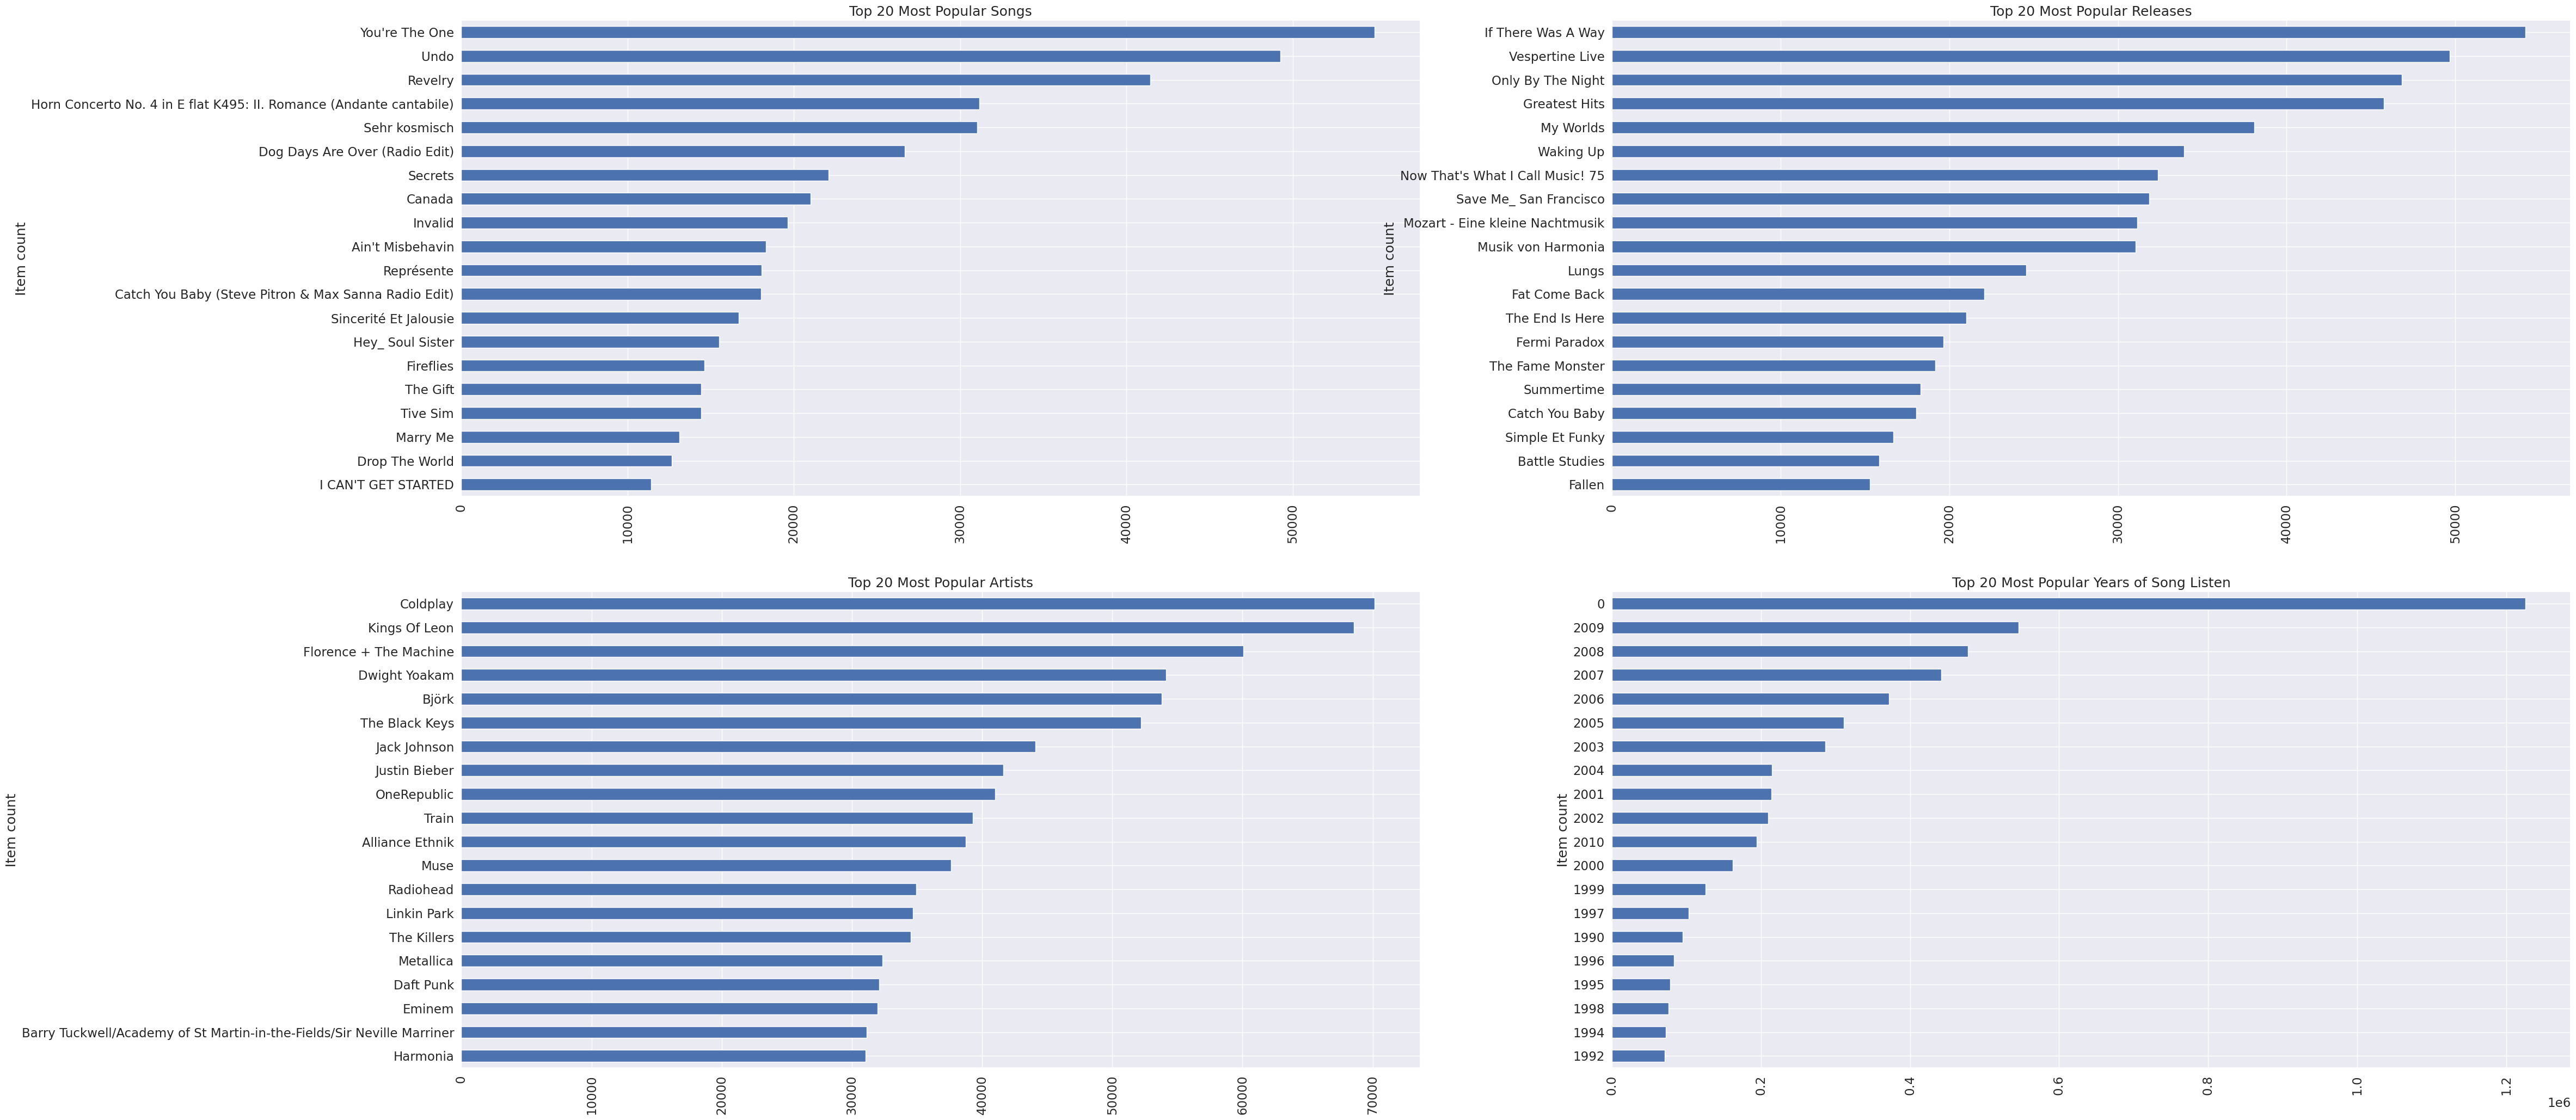

In [12]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a4 = fig.add_subplot(224)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

In [13]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

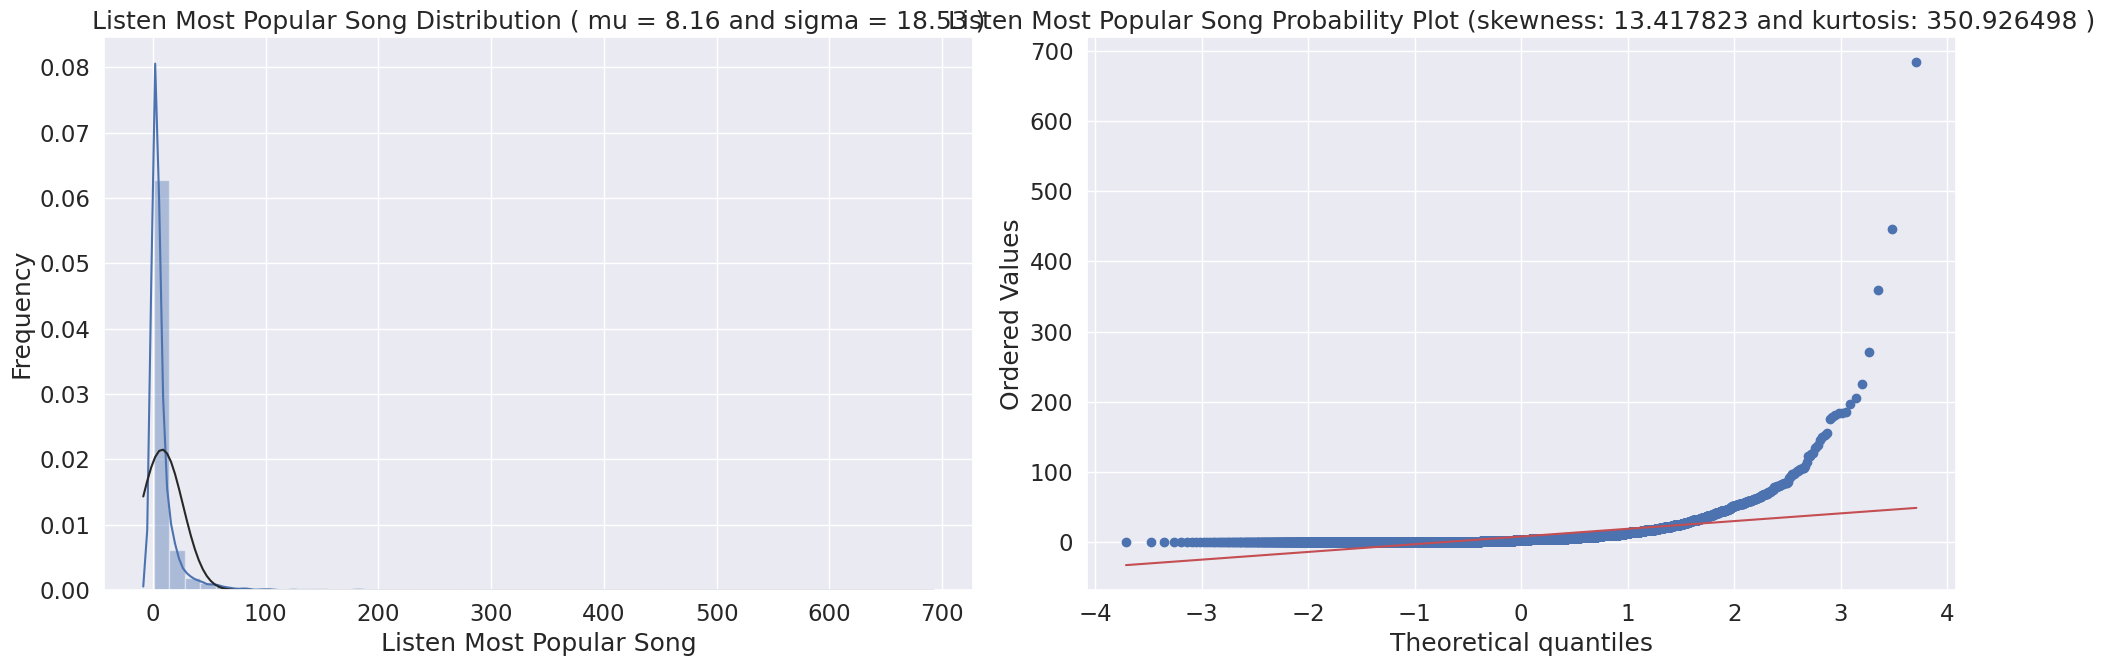

In [14]:
QQ_plot(user_song_list_count[user_song_list_count.title=="You're The One"].listen_count, 'Listen Most Popular Song')

In [15]:
def create_popularity_recommendation(train_data, user_id, item_id, n=10):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)

    #Sort the songs based upon recommendation score
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])

    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort.score.rank(ascending=0, method='first')

    #Get the top n recommendations
    popularity_recommendations = train_data_sort.head(n)
    return popularity_recommendations

In [16]:
recommendations = create_popularity_recommendation(user_song_list_count,'user','title', 15)
display(recommendations)

,title,score,Rank
6837,Sehr kosmisch,8277,1.0
8726,Undo,7032,2.0
1965,Dog Days Are Over (Radio Edit),6949,3.0
9497,You're The One,6729,4.0
6499,Revelry,6145,5.0
6826,Secrets,5841,6.0
3438,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,7.0
2596,Fireflies,4795,8.0
3323,Hey_ Soul Sister,4758,9.0
8495,Tive Sim,4548,10.0


In [17]:
display(create_popularity_recommendation(user_song_list_count,'user','artist_name', 10))

,artist_name,score,Rank
649,Coldplay,29422,1.0
2850,The Black Keys,19862,2.0
1651,Kings Of Leon,18747,3.0
1107,Florence + The Machine,18112,4.0
1370,Jack Johnson,17801,5.0
2946,The Killers,16063,6.0
2374,Radiohead,14890,7.0
736,Daft Punk,14715,8.0
2073,Muse,14005,9.0
1554,Justin Bieber,13959,10.0


In [18]:
total_play_count = sum(user_song_list_count.listen_count)
play_count = user_song_list_count[['song', 'listen_count']].groupby('song').sum().\
             sort_values(by='listen_count',ascending=False).head(5000)

print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))

song_subset = list(play_count.index[:5000])
user_subset = list(user_song_list_count.loc[user_song_list_count.song.isin(song_subset), 'user'].unique())
user_song_list_count_sub = user_song_list_count[user_song_list_count.song.isin(song_subset)]
display(user_song_list_count_sub.head())

5,000 most popular songs represents 81.88% of total listen.


,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [20]:
is_model = item_similarity_recommender_py()
is_model.create(user_song_list_count_sub, 'user', 'title')
user_id = list(user_song_list_count_sub.user)[7]
user_items = is_model.get_user_items(user_id)

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

No. of unique songs for the user: 33
no. of unique songs in the training set: 4867
Non zero values in cooccurence_matrix :120655


,user_id,song,score,rank
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Quiet Houses,0.044710,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Meadowlarks,0.043836,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Heard Them Stirring,0.042740,3
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Tiger Mountain Peasant Song,0.041485,4
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Sun It Rises,0.040973,5
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Your Protector,0.039942,6
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Oliver James,0.039287,7
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Great Indoors,0.036765,8
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,White Winter Hymnal,0.036345,9
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,If I Could,0.034576,10


In [21]:
display(user_song_list_count_sub[(user_song_list_count_sub.user==user_id) & (user_song_list_count_sub.listen_count>5)])

,user,song,listen_count,title,release,artist_name,year
16,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOMGIYR12AB0187973,6,Behind The Sea [Live In Chicago],Live In Chicago,Panic At The Disco,0
43,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOYHEPA12A8C13097F,8,Moonshine,Thicker Than Water,Jack Johnson,2003


In [22]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)

    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings
def show_recomendations(uTest, num_recomendations = 10):
    for user in uTest:
        print('-'*70)
        print("Recommendation for user id {}".format(user))
        rank_value = 1
        i = 0
        while (rank_value <  num_recomendations + 1):
            so = uTest_recommended_items[user,i:i+1][0]
            if (small_set.user[(small_set.so_index_value == so) & (small_set.us_index_value == user)].count()==0):
                song_details = small_set[(small_set.so_index_value == so)].\
                    drop_duplicates('so_index_value')[['title','artist_name']]
                print("The number {} recommended song is {} BY {}".format(rank_value,
                                                                      list(song_details['title'])[0],
                                                                      list(song_details['artist_name'])[0]))
                rank_value+=1
            i += 1

In [23]:
user_song_list_listen = user_song_list_count[['user','listen_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
user_song_list_count_merged = pd.merge(user_song_list_count,user_song_list_listen)
user_song_list_count_merged['fractional_play_count'] = \
    user_song_list_count_merged['listen_count']/user_song_list_count_merged['total_listen_count']

display(user_song_list_count_merged[user_song_list_count_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea']\
        [['user','song','listen_count','fractional_play_count']].head())

,user,song,listen_count,fractional_play_count
299,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.038961
300,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003247
301,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003247
302,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003247
303,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.022727


In [24]:
user_codes = user_song_list_count_merged.user.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['us_index_value'] = list(user_codes.index)

song_codes = user_song_list_count_merged.song.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)

small_set = pd.merge(user_song_list_count_merged,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]

data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

display(data_sparse)

print('User used to performed the item similarity based recommendations earlie:.')
display(user_codes[user_codes.user =='b80344d063b5ccb3212f76538f3d9e43d87dca9e'])

<76353x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2000000 stored elements in COOrdinate format>

User used to performed the item similarity based recommendations earlie:.


,user_index,user,us_index_value
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,0


In [25]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

urm = np.nan_to_num(urm)

U, S, Vt = compute_svd(urm, K)
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

show_recomendations(uTest)

----------------------------------------------------------------------
Recommendation for user id 4
The number 1 recommended song is 911 BY Wyclef Jean / Mary J. Blige
The number 2 recommended song is If I Ain't Got You BY Alicia Keys
The number 3 recommended song is Sample Track 2 BY Simon Harris
The number 4 recommended song is Kennedy Rag BY Suzy Thompson
The number 5 recommended song is Clocks BY Coldplay
The number 6 recommended song is Yellow BY Coldplay
The number 7 recommended song is Hey_ Soul Sister BY Train
The number 8 recommended song is The Scientist BY Coldplay
The number 9 recommended song is Eco BY Jorge Drexler
The number 10 recommended song is Kryptonite BY 3 Doors Down
----------------------------------------------------------------------
Recommendation for user id 5
The number 1 recommended song is Eenie Meenie BY Sean Kingston and Justin Bieber
The number 2 recommended song is Sample Track 2 BY Simon Harris
The number 3 recommended song is U Smile BY Justin Bieber

In [26]:
uTest = [0]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
show_recomendations(uTest)

Predictied ratings:
----------------------------------------------------------------------
Recommendation for user id 0
The number 1 recommended song is Basic Space BY The xx
The number 2 recommended song is Infinity BY The xx
The number 3 recommended song is I Wanna Be Sedated (Remastered Album Version ) BY Ramones
The number 4 recommended song is Fantasy BY The xx
The number 5 recommended song is The Big Gundown BY The Prodigy
The number 6 recommended song is CIEÑ BY Milczenie Owiec
The number 7 recommended song is Home BY Edward Sharpe & The Magnetic Zeros
The number 8 recommended song is Cosmic Love BY Florence + The Machine
The number 9 recommended song is Speak BY Godsmack
The number 10 recommended song is You've Got The Love BY Florence + The Machine
